In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import warnings
warnings.simplefilter('ignore')


训练的一些参数

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)

使用 PyTorch 内置的 DataLoader 对 MNIST 数据集进行加载和预处理（将图片像素值转化为张量、将值缩放到 [0, 1] 区间、对图像进行标准化）

In [3]:
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('./data/', train = True, download = True,
                               transform = torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307, ), (0.3081, ))])), batch_size = batch_size_train, shuffle = True)
test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('./data/', train = False, download = True,
                               transform = torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307, ), (0.3081, ))])), batch_size = batch_size_test, shuffle = True)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_targets[:10])
print(example_data.shape)

tensor([3, 9, 4, 9, 9, 0, 8, 3, 1, 2])
torch.Size([1000, 1, 28, 28])


数字分布情况

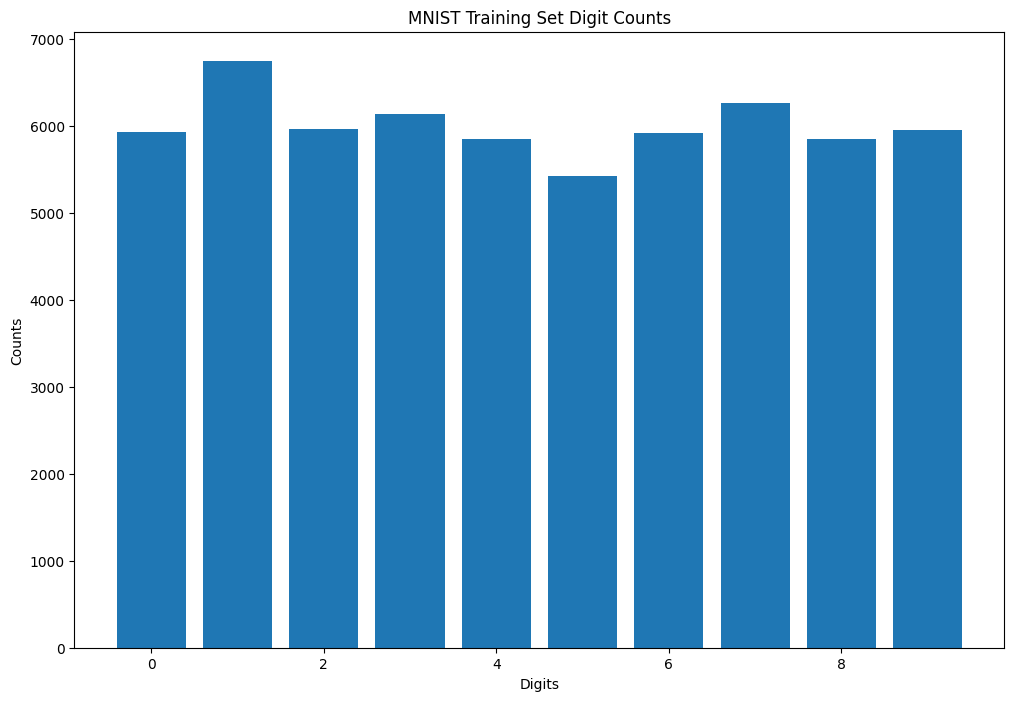

In [5]:
# 加载MNIST数据集
train_set = torchvision.datasets.MNIST('./data/', train=True, download=True, transform=torchvision.transforms.ToTensor())

# 遍历训练集并计数每个数字的数量
counts = [0] * 10
for image, label in train_set:
    counts[label] += 1

# 使用Matplotlib创建条形图
fig, ax = plt.subplots(figsize = (12, 8))
ax.bar(range(10), counts)
ax.set_xlabel('Digits')
ax.set_ylabel('Counts')
ax.set_title('MNIST Training Set Digit Counts')
plt.show()

数据集的展示（50个）

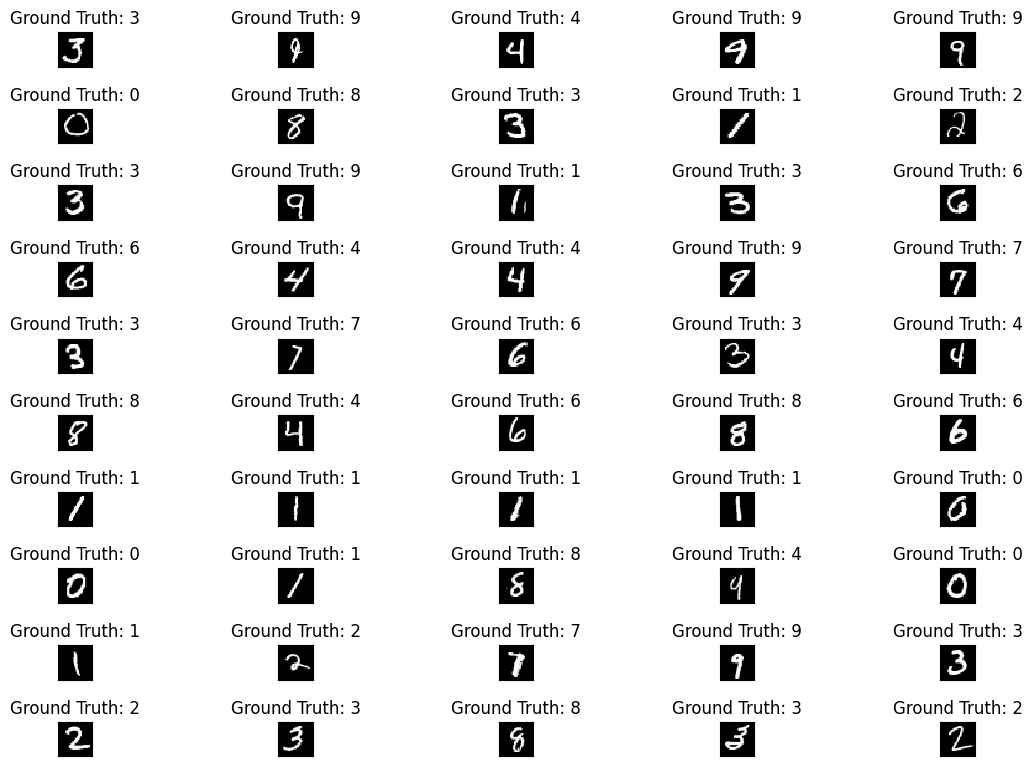

In [7]:
fig = plt.figure(figsize = (12, 8))
for i in range(50):
  plt.subplot(10, 5, i + 1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap = 'gray', interpolation = 'none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

一层卷积核，尺寸3 * 3

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Conv2d(1, 10, kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(10 * 14 * 14, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv(x), 2))
        x = x.view(-1, 10 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

Test set: Average loss: 2.3135, Accuracy: 1275/10000 (13%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296525
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.260349
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.159883
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.950913
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.778374
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.764026
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.399346
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.313420
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.046932
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.981900
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.847817
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.881190
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.772412
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.711463
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.590218
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.906064
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.625248
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.711716
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.856906
Train Epoch: 1 [1216

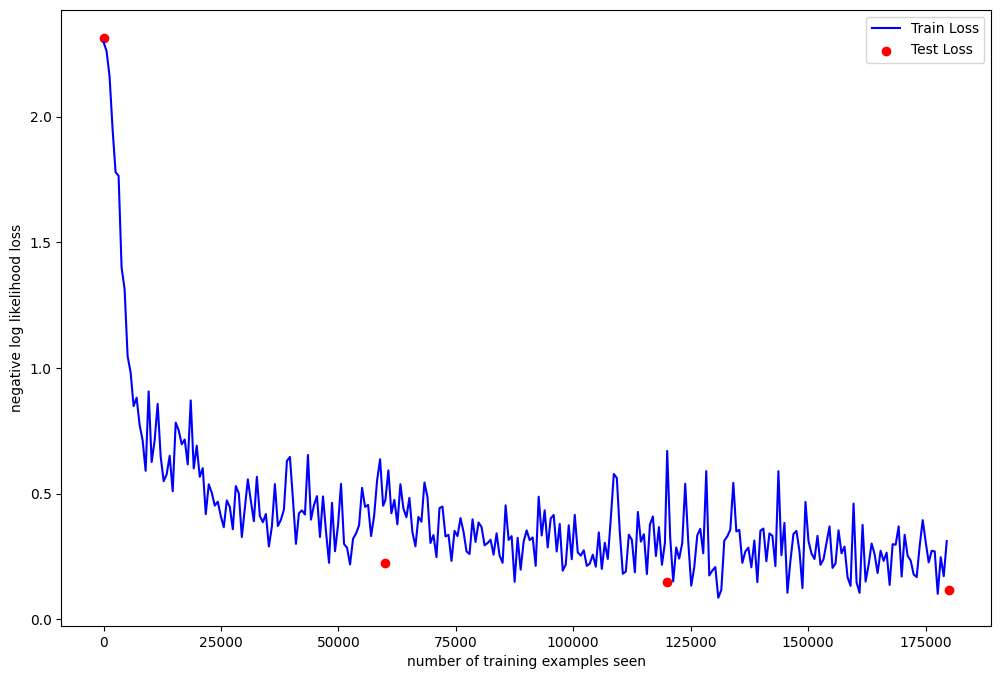

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr = learning_rate, momentum = momentum)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))
            torch.save(network.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average = False).item()
            pred = output.data.max(1, keepdim = True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.5f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

fig = plt.figure(figsize = (12, 8))
plt.plot(train_counter, train_losses, color = 'blue')
plt.scatter(test_counter, test_losses, color = 'red')
plt.legend(['Train Loss', 'Test Loss'], loc = 'upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

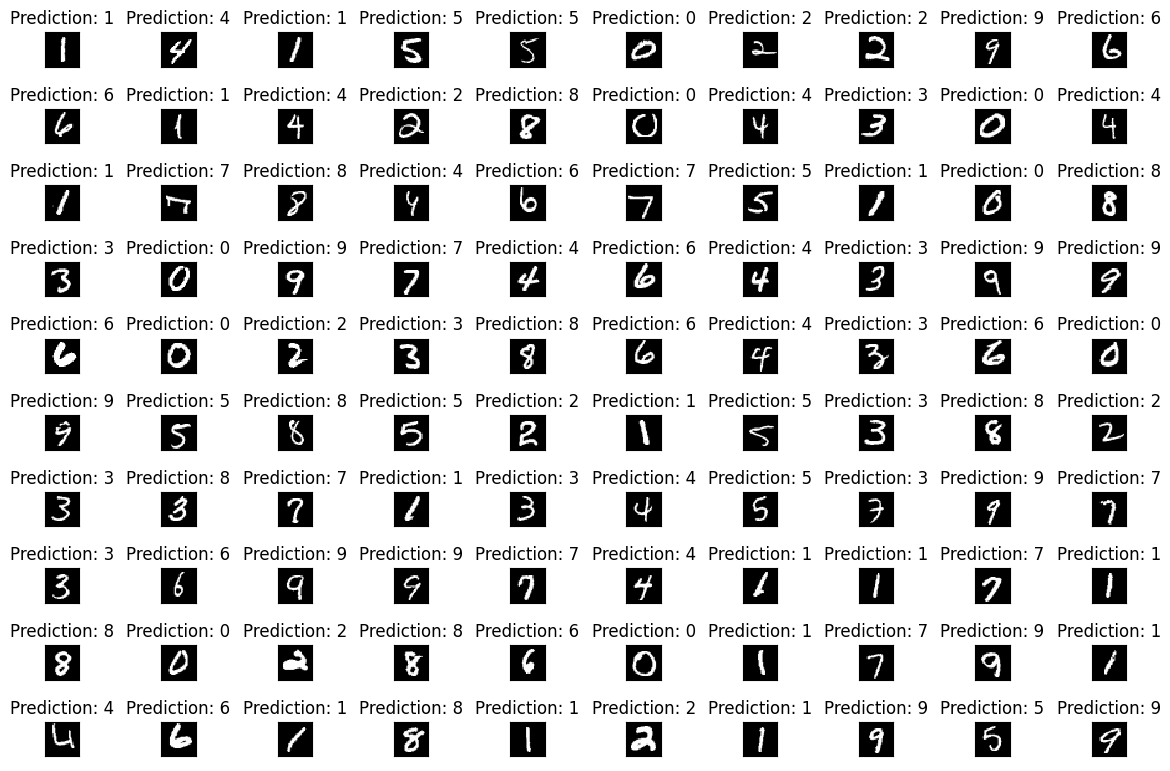

In [13]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    example_data = example_data.to(device)
    output = network(example_data)
fig = plt.figure(figsize = (12, 8))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0].cpu(), cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [35]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Conv2d(1, 10, kernel_size=2)
        self.fc1 = nn.Linear(10 * 13 * 13, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv(x), 2))
        x = x.view(-1, 10 * 13 * 13)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Test set: Average loss: 2.3136, Accuracy: 816/10000 (8.16000%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303514
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.224487
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.081598
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.959255
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.721257
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.683057
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.651721
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.146765
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.231042
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.223928
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.816502
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.016393
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.926789
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.752171
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.008920
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.801858
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.880517
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.833500
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.915441
Train Epoch: 1 [

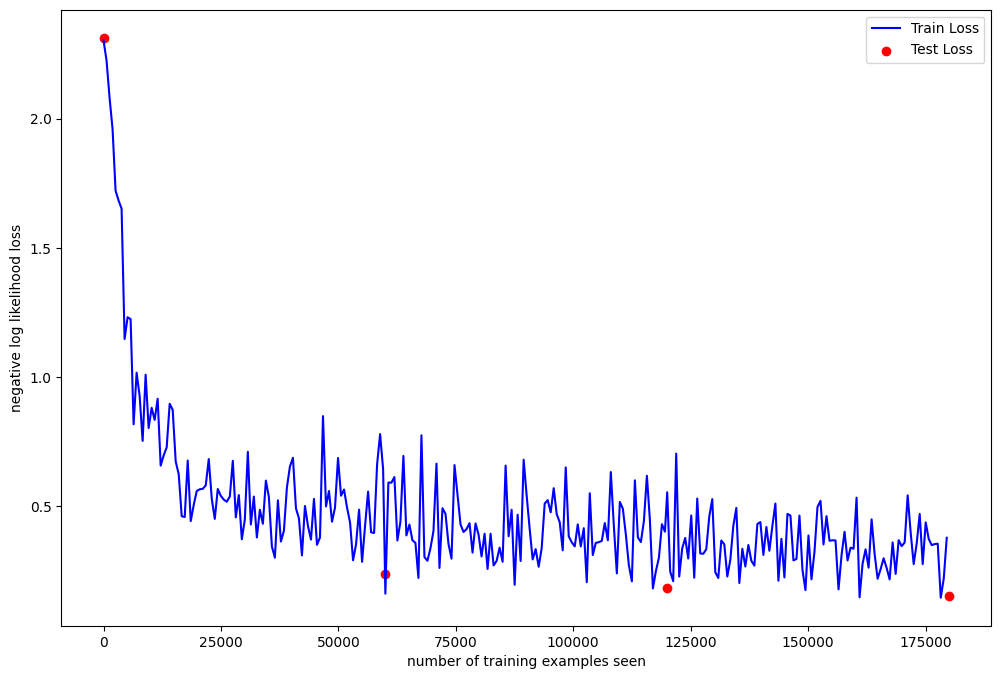

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr = learning_rate, momentum = momentum)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))
            torch.save(network.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average = False).item()
            pred = output.data.max(1, keepdim = True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.5f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

fig = plt.figure(figsize = (12, 8))
plt.plot(train_counter, train_losses, color = 'blue')
plt.scatter(test_counter, test_losses, color = 'red')
plt.legend(['Train Loss', 'Test Loss'], loc = 'upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

两层卷积层，3 * 3

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(20 * 7 * 7, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 20 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

Test set: Average loss: 2.3132, Accuracy: 936/10000 (9%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.314169
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.301028
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.289658
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.268634
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.271391
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.267976
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.210621
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.175446
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.143637
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.085764
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.934412
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.794435
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.521319
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.304649
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.935844
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.814898
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.747763
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.621901
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.721590
Train Epoch: 1 [12160/

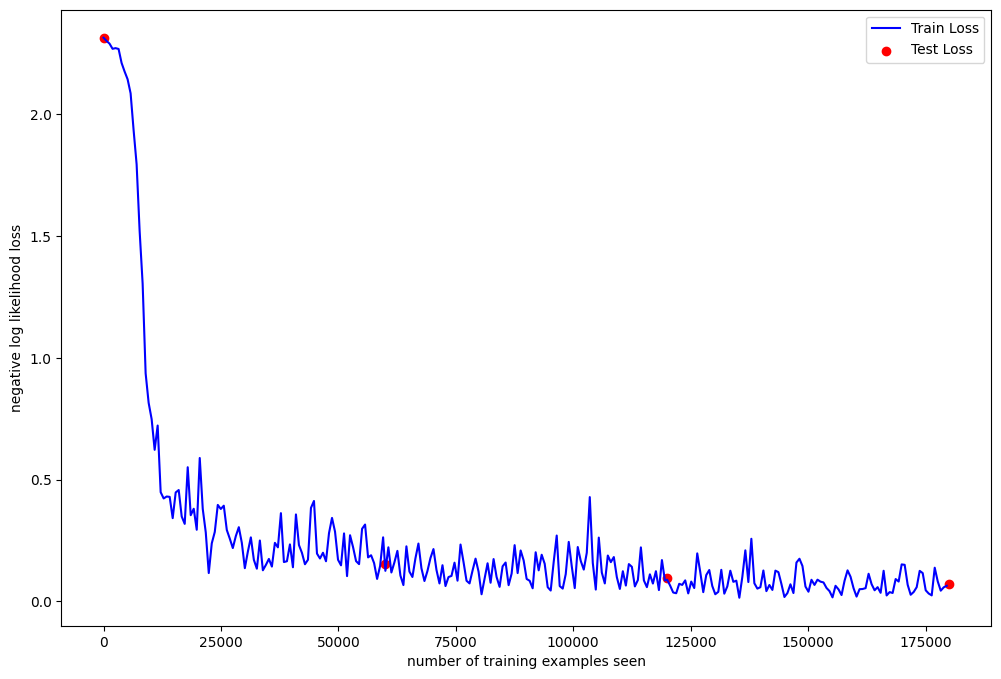

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr = learning_rate, momentum = momentum)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))
            torch.save(network.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average = False).item()
            pred = output.data.max(1, keepdim = True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.5f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

fig = plt.figure(figsize = (12, 8))
plt.plot(train_counter, train_losses, color = 'blue')
plt.scatter(test_counter, test_losses, color = 'red')
plt.legend(['Train Loss', 'Test Loss'], loc = 'upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

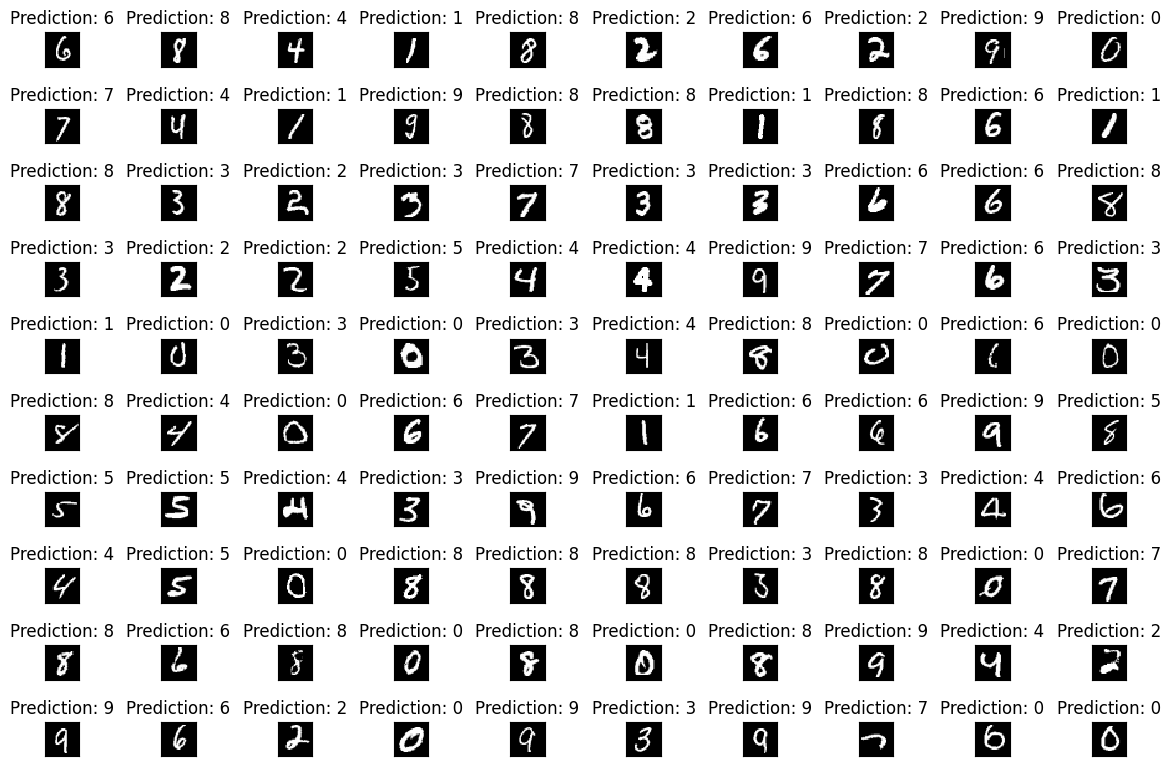

In [16]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    example_data = example_data.to(device)
    output = network(example_data)
fig = plt.figure(figsize = (12, 8))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0].cpu(), cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
plt.show()

两层卷积加入dropout层

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(20 * 7 * 7, 50)
        self.fc2 = nn.Linear(50, 10)
        self.dropout = nn.Dropout(p = 0.2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 20 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

Test set: Average loss: 2.3043, Accuracy: 1150/10000 (12%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.357994
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.251816
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.206097
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.141326
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.969183
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.783544
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.377260
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.376794
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.951962
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.971437
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.942422
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.962116
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.646438
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.854123
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.781952
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.753172
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.764309
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.654349
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.510265
Train Epoch: 1 [1216

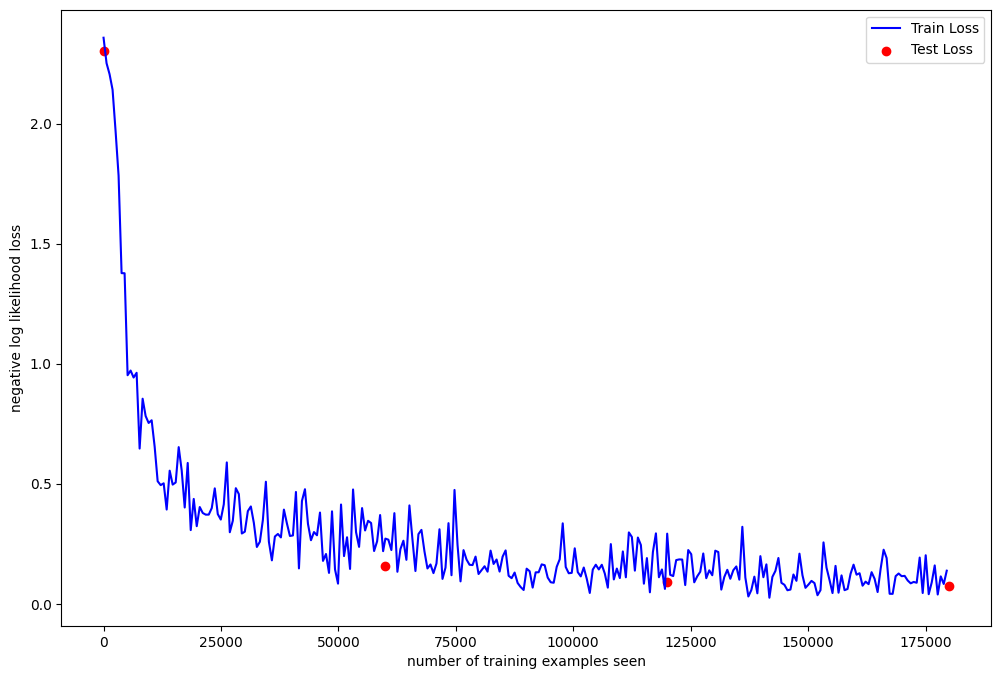

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr = learning_rate, momentum = momentum)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))
            torch.save(network.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average = False).item()
            pred = output.data.max(1, keepdim = True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.5f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

fig = plt.figure(figsize = (12, 8))
plt.plot(train_counter, train_losses, color = 'blue')
plt.scatter(test_counter, test_losses, color = 'red')
plt.legend(['Train Loss', 'Test Loss'], loc = 'upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

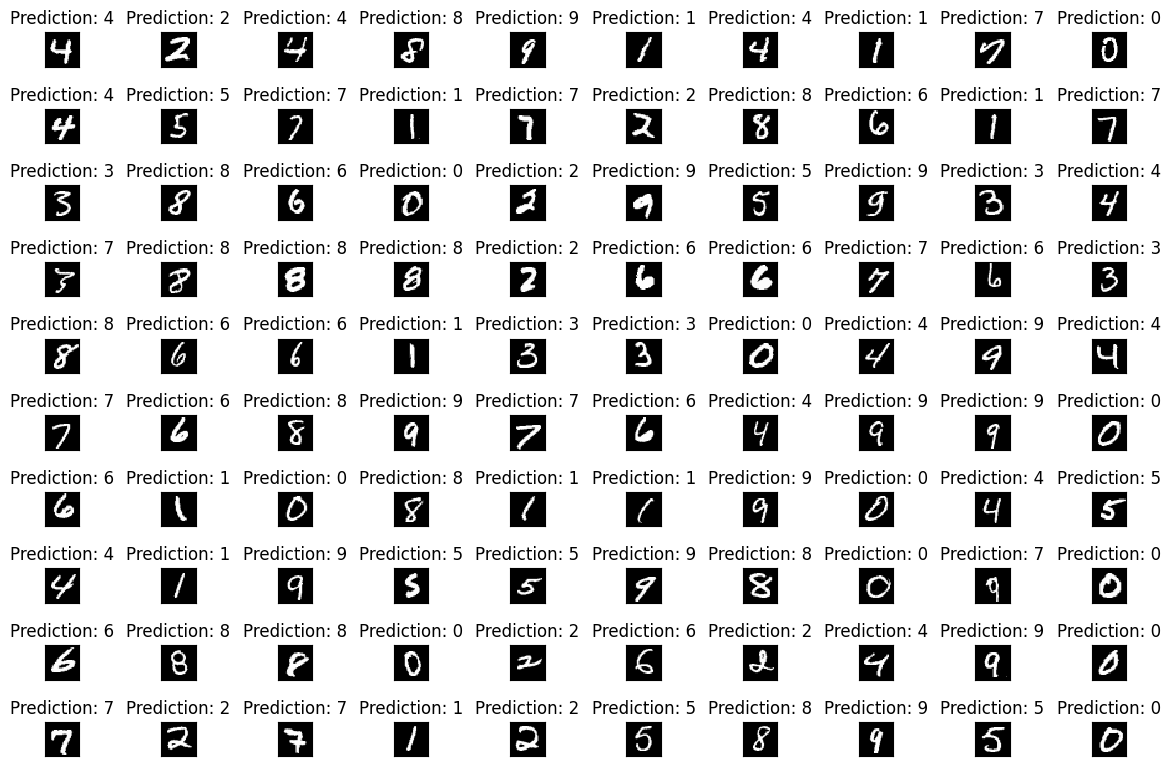

In [20]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    example_data = example_data.to(device)
    output = network(example_data)
fig = plt.figure(figsize = (12, 8))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0].cpu(), cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
plt.show()

三层卷积

In [21]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 64 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

Test set: Average loss: 2.3070, Accuracy: 932/10000 (9%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.314517
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.300328
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.291883
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.291850
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.277582
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.276003
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.286793
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.262369
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.252289
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.258680
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.226966
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.193997
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.165606
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.106999
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.059046
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.029324
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.802293
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.607927
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.530475
Train Epoch: 1 [12160/

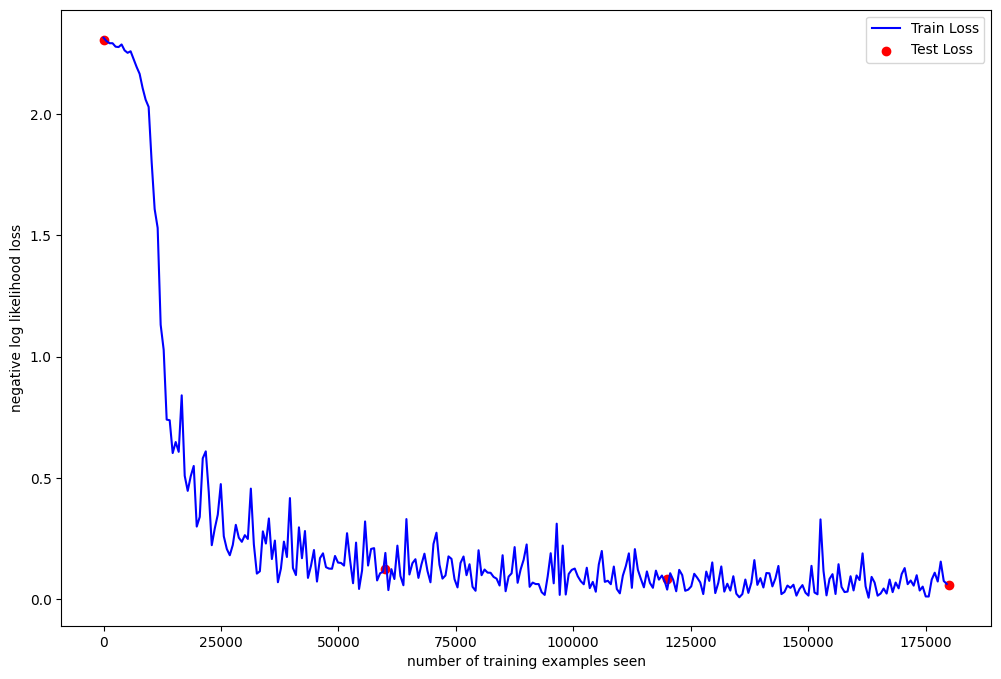

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr = learning_rate, momentum = momentum)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))
            torch.save(network.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average = False).item()
            pred = output.data.max(1, keepdim = True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.5f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

fig = plt.figure(figsize = (12, 8))
plt.plot(train_counter, train_losses, color = 'blue')
plt.scatter(test_counter, test_losses, color = 'red')
plt.legend(['Train Loss', 'Test Loss'], loc = 'upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 64*3*3)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Test set: Average loss: 2.3068, Accuracy: 1010/10000 (10%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309904
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.310163
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.285998
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.288853
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.284384
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.282002
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.289480
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.292137
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.279285
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.288553
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.252862
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.223325
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.227111
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.177956
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.084508
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.067381
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.010875
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.882567
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.650241
Train Epoch: 1 [1216

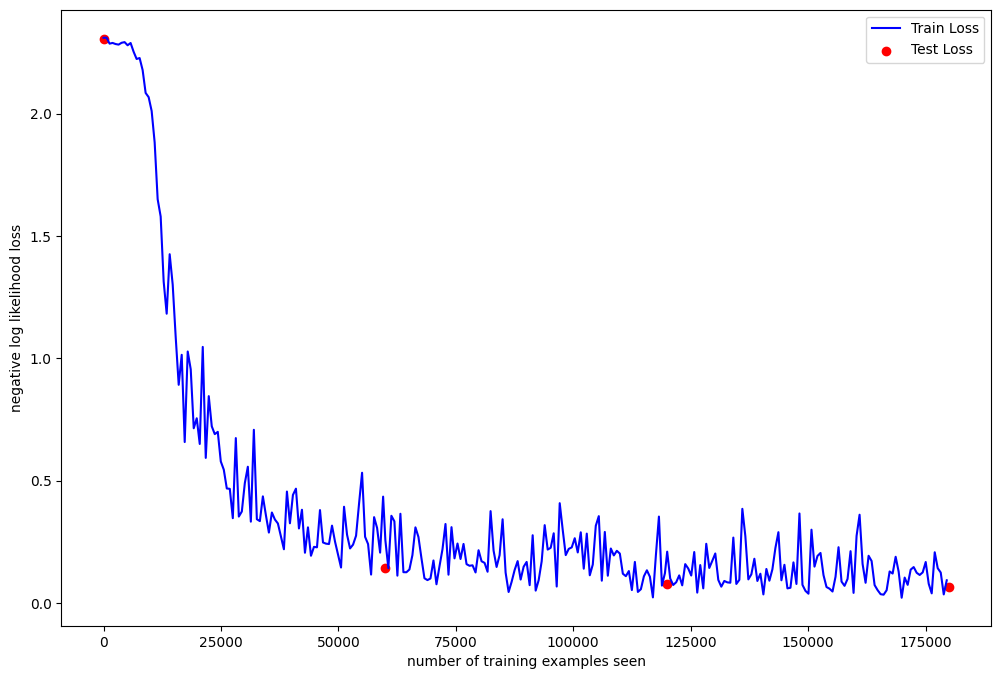

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr = learning_rate, momentum = momentum)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))
            torch.save(network.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average = False).item()
            pred = output.data.max(1, keepdim = True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.5f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

fig = plt.figure(figsize = (12, 8))
plt.plot(train_counter, train_losses, color = 'blue')
plt.scatter(test_counter, test_losses, color = 'red')
plt.legend(['Train Loss', 'Test Loss'], loc = 'upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

四层

In [29]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((3, 3))
        self.fc1 = nn.Linear(128*3*3, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.relu(F.max_pool2d(self.conv4(x), 2))
        x = self.pool(x)
        x = x.view(-1, 128*3*3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Test set: Average loss: 2.3052, Accuracy: 988/10000 (10%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302113
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.309339
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.298823
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.301364
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.292631
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.303271
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.295020
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.298942
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.287393
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.287015
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.289025
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.277321
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.273846
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.267037
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.267844
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.240207
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.226671
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.194627
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.184642
Train Epoch: 1 [12160

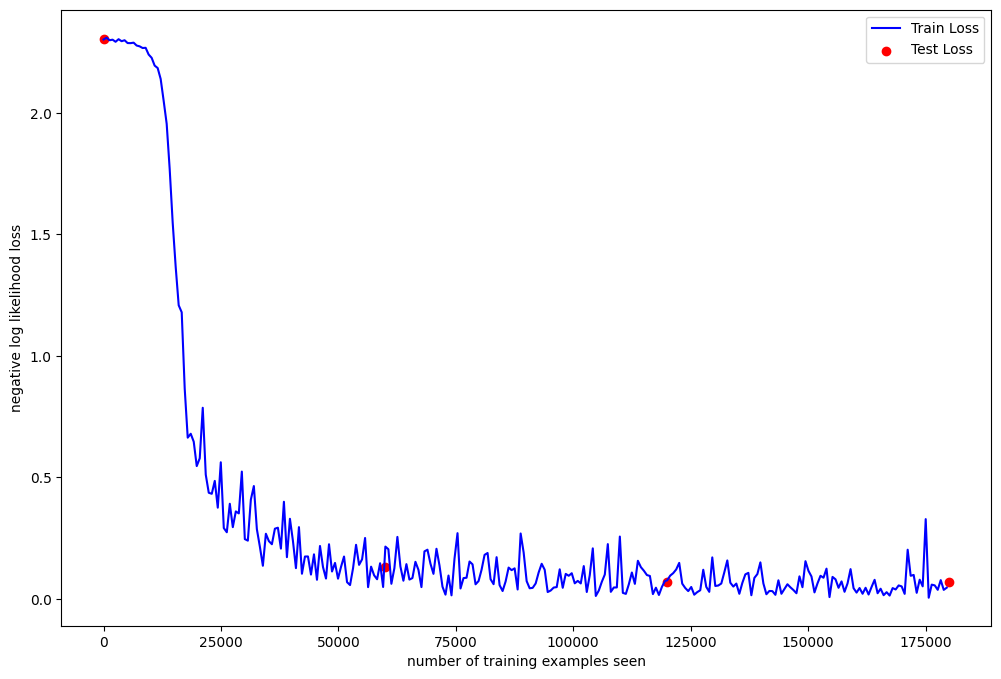

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr = learning_rate, momentum = momentum)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))
            torch.save(network.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average = False).item()
            pred = output.data.max(1, keepdim = True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.5f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

fig = plt.figure(figsize = (12, 8))
plt.plot(train_counter, train_losses, color = 'blue')
plt.scatter(test_counter, test_losses, color = 'red')
plt.legend(['Train Loss', 'Test Loss'], loc = 'upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

加入dropout

In [31]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((3, 3))
        self.fc1 = nn.Linear(128*3*3, 256)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.relu(F.max_pool2d(self.conv4(x), 2))
        x = self.pool(x)
        x = x.view(-1, 128*3*3)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Test set: Average loss: 2.3064, Accuracy: 891/10000 (9%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303997
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.300647
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.294383
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.304849
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.302469
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.299722
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.285202
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.279086
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.290372
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.278448
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.286692
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.276628
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.257924
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.258174
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.244613
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.239621
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.201531
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.196218
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.124957
Train Epoch: 1 [12160/

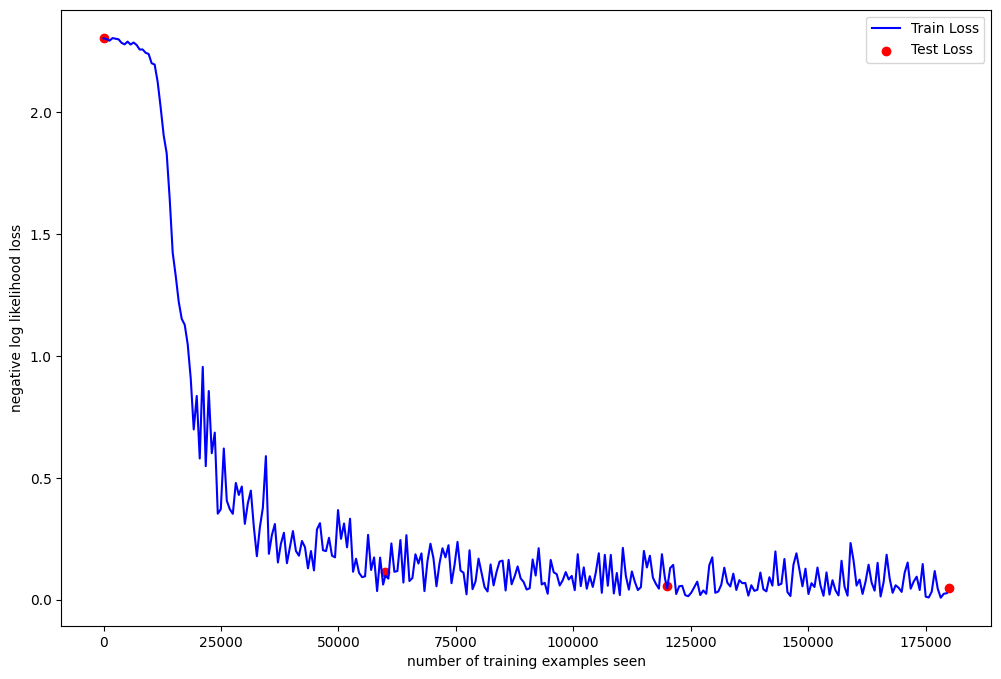

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr = learning_rate, momentum = momentum)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))
            torch.save(network.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average = False).item()
            pred = output.data.max(1, keepdim = True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.5f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

fig = plt.figure(figsize = (12, 8))
plt.plot(train_counter, train_losses, color = 'blue')
plt.scatter(test_counter, test_losses, color = 'red')
plt.legend(['Train Loss', 'Test Loss'], loc = 'upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

优化

In [84]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr = learning_rate, momentum = momentum)
network_state_dict = torch.load('model.pth')
continued_network.load_state_dict(network_state_dict)
optimizer_state_dict = torch.load('optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [85]:
for i in range(4, 9):
    test_counter.append(i * len(train_loader.dataset))
    train(i)
    test()

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.141029
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.422132
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.279750
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.179099
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.237239
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.316775
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.170664
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.242446
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.179156
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.107642
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.393581
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.297491
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.400682
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.331698
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.168010
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.246711
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.305276
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.229265
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.303983
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.265500
Train Epoch: 4 [12800/60000 (

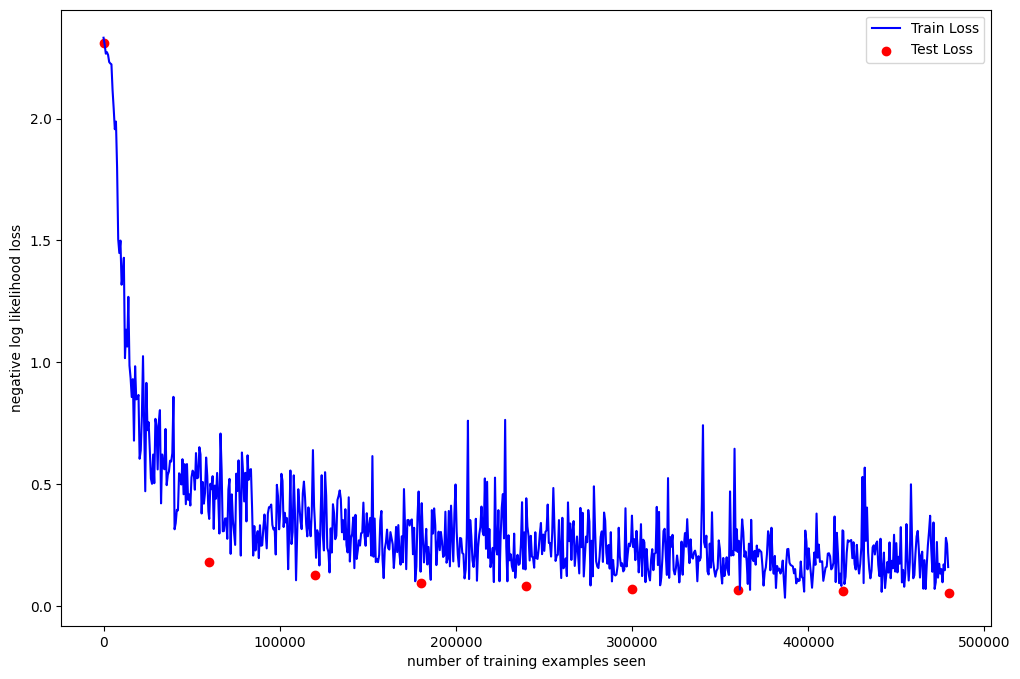

In [86]:
fig = plt.figure(figsize = (12, 8))
plt.plot(train_counter, train_losses, color = 'blue')
plt.scatter(test_counter, test_losses, color = 'red')
plt.legend(['Train Loss', 'Test Loss'], loc = 'upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

In [2]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch
import torch.utils.data
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchstat import stat

In [3]:
class Model_1(nn.Module):

    def __init__(self, num_classes=10):
        super(Model_1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            # 特征图大小：16@26*26
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 特征图大小：16@13*13
        )
        self.classifier = nn.Sequential(
            nn.Linear(16*13*13, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x
model = Model_1()
stat(model, (1, 28, 28))

        module name  input shape output shape    params memory(MB)         MAdd      Flops  MemRead(B)  MemWrite(B) duration[%]  MemR+W(B)
0        features.0    1  28  28   16  26  26     160.0       0.04    194,688.0  108,160.0      3776.0      43264.0     100.00%    47040.0
1        features.1   16  26  26   16  26  26       0.0       0.04     10,816.0   10,816.0     43264.0      43264.0       0.00%    86528.0
2        features.2   16  26  26   16  13  13       0.0       0.01      8,112.0   10,816.0     43264.0      10816.0       0.00%    54080.0
3      classifier.0         2704          256  692480.0       0.00  1,384,192.0  692,224.0   2780736.0       1024.0       0.00%  2781760.0
4      classifier.1          256          256       0.0       0.00        256.0      256.0      1024.0       1024.0       0.00%     2048.0
5      classifier.2          256           10    2570.0       0.00      5,110.0    2,560.0     11304.0         40.0       0.00%    11344.0
total                      

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [4]:
class Model_2(nn.Module):

    def __init__(self, num_classes=10):
        super(Model_2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            # 特征图大小：16@26*26
            nn.Sigmoid(),
            nn.MaxPool2d(2),
            # 特征图大小：16@13*13
        )
        self.classifier = nn.Sequential(
            nn.Linear(16*13*13, 256),
            nn.Sigmoid(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x
    
model = Model_2()
stat(model, (1, 28, 28))

[MAdd]: Sigmoid is not supported!
[Flops]: Sigmoid is not supported!
[Memory]: Sigmoid is not supported!
[MAdd]: Sigmoid is not supported!
[Flops]: Sigmoid is not supported!
[Memory]: Sigmoid is not supported!
        module name  input shape output shape    params memory(MB)         MAdd      Flops  MemRead(B)  MemWrite(B) duration[%]  MemR+W(B)
0        features.0    1  28  28   16  26  26     160.0       0.04    194,688.0  108,160.0      3776.0      43264.0       0.00%    47040.0
1        features.1   16  26  26   16  26  26       0.0       0.04          0.0        0.0         0.0          0.0      89.31%        0.0
2        features.2   16  26  26   16  13  13       0.0       0.01      8,112.0   10,816.0     43264.0      10816.0      10.69%    54080.0
3      classifier.0         2704          256  692480.0       0.00  1,384,192.0  692,224.0   2780736.0       1024.0       0.00%  2781760.0
4      classifier.1          256          256       0.0       0.00          0.0        0.0     

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [5]:
class Model_3(nn.Module):

    def __init__(self, num_classes=10):
        super(Model_3, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            # 特征图大小：16@26*26
            nn.Tanh(),
            nn.MaxPool2d(2),
            # 特征图大小：16@13*13
        )
        self.classifier = nn.Sequential(
            nn.Linear(16*13*13, 256),
            nn.Tanh(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x
model = Model_3()
stat(model, (1, 28, 28))

[MAdd]: Tanh is not supported!
[Flops]: Tanh is not supported!
[Memory]: Tanh is not supported!
[MAdd]: Tanh is not supported!
[Flops]: Tanh is not supported!
[Memory]: Tanh is not supported!
        module name  input shape output shape    params memory(MB)         MAdd      Flops  MemRead(B)  MemWrite(B) duration[%]  MemR+W(B)
0        features.0    1  28  28   16  26  26     160.0       0.04    194,688.0  108,160.0      3776.0      43264.0       0.00%    47040.0
1        features.1   16  26  26   16  26  26       0.0       0.04          0.0        0.0         0.0          0.0      38.80%        0.0
2        features.2   16  26  26   16  13  13       0.0       0.01      8,112.0   10,816.0     43264.0      10816.0      51.70%    54080.0
3      classifier.0         2704          256  692480.0       0.00  1,384,192.0  692,224.0   2780736.0       1024.0       9.51%  2781760.0
4      classifier.1          256          256       0.0       0.00          0.0        0.0         0.0          0

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [6]:
class Model_4(nn.Module):

    def __init__(self, num_classes=10):
        super(Model_4, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            # 特征图大小：16@26*26
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            # 特征图大小：16@13*13
        )
        self.classifier = nn.Sequential(
            nn.Linear(16*13*13, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x
model = Model_4()
stat(model, (1, 28, 28))

[MAdd]: LeakyReLU is not supported!
[MAdd]: LeakyReLU is not supported!
        module name  input shape output shape    params memory(MB)         MAdd      Flops  MemRead(B)  MemWrite(B) duration[%]  MemR+W(B)
0        features.0    1  28  28   16  26  26     160.0       0.04    194,688.0  108,160.0      3776.0      43264.0      15.59%    47040.0
1        features.1   16  26  26   16  26  26       0.0       0.04          0.0   10,816.0     43264.0      43264.0      84.41%    86528.0
2        features.2   16  26  26   16  13  13       0.0       0.01      8,112.0   10,816.0     43264.0      10816.0       0.00%    54080.0
3      classifier.0         2704          256  692480.0       0.00  1,384,192.0  692,224.0   2780736.0       1024.0       0.00%  2781760.0
4      classifier.1          256          256       0.0       0.00          0.0      256.0      1024.0       1024.0       0.00%     2048.0
5      classifier.2          256           10    2570.0       0.00      5,110.0    2,560.0    

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [7]:
class Model_1(nn.Module):

    def __init__(self, num_classes=10):
        super(Model_1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            # 特征图大小：16@26*26
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 特征图大小：16@13*13
        )
        self.classifier = nn.Sequential(
            nn.Linear(16*13*13, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x
model = Model_1()
stat(model, (1, 28, 28))

        module name  input shape output shape    params memory(MB)         MAdd      Flops  MemRead(B)  MemWrite(B) duration[%]  MemR+W(B)
0        features.0    1  28  28   16  26  26     160.0       0.04    194,688.0  108,160.0      3776.0      43264.0      48.65%    47040.0
1        features.1   16  26  26   16  26  26       0.0       0.04     10,816.0   10,816.0     43264.0      43264.0      21.93%    86528.0
2        features.2   16  26  26   16  13  13       0.0       0.01      8,112.0   10,816.0     43264.0      10816.0       7.55%    54080.0
3      classifier.0         2704          256  692480.0       0.00  1,384,192.0  692,224.0   2780736.0       1024.0      10.93%  2781760.0
4      classifier.1          256          256       0.0       0.00        256.0      256.0      1024.0       1024.0       0.00%     2048.0
5      classifier.2          256           10    2570.0       0.00      5,110.0    2,560.0     11304.0         40.0      10.93%    11344.0
total                      

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [8]:
class Model_2(nn.Module):

    def __init__(self, num_classes=10):
        super(Model_2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            # 特征图大小：32@26*26
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 特征图大小：32@13*13
        )
        self.classifier = nn.Sequential(
            nn.Linear(32*13*13, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x
model = Model_2()
stat(model, (1, 28, 28))

        module name  input shape output shape     params memory(MB)         MAdd        Flops  MemRead(B)  MemWrite(B) duration[%]  MemR+W(B)
0        features.0    1  28  28   32  26  26      320.0       0.08    389,376.0    216,320.0      4416.0      86528.0      32.11%    90944.0
1        features.1   32  26  26   32  26  26        0.0       0.08     21,632.0     21,632.0     86528.0      86528.0       0.00%   173056.0
2        features.2   32  26  26   32  13  13        0.0       0.02     16,224.0     21,632.0     86528.0      21632.0      67.88%   108160.0
3      classifier.0         5408          256  1384704.0       0.00  2,768,640.0  1,384,448.0   5560448.0       1024.0       0.00%  5561472.0
4      classifier.1          256          256        0.0       0.00        256.0        256.0      1024.0       1024.0       0.00%     2048.0
5      classifier.2          256           10     2570.0       0.00      5,110.0      2,560.0     11304.0         40.0       0.00%    11344.0
total 

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [9]:
class Model_3(nn.Module):

    def __init__(self, num_classes=10):
        super(Model_3, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 48, kernel_size=3),
            # 特征图大小：48@26*26
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 特征图大小：48@13*13
        )
        self.classifier = nn.Sequential(
            nn.Linear(48*13*13, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x
    
model = Model_3()
stat(model, (1, 28, 28))

        module name  input shape output shape     params memory(MB)         MAdd        Flops  MemRead(B)  MemWrite(B) duration[%]  MemR+W(B)
0        features.0    1  28  28   48  26  26      480.0       0.12    584,064.0    324,480.0      5056.0     129792.0       0.00%   134848.0
1        features.1   48  26  26   48  26  26        0.0       0.12     32,448.0     32,448.0    129792.0     129792.0       0.00%   259584.0
2        features.2   48  26  26   48  13  13        0.0       0.03     24,336.0     32,448.0    129792.0      32448.0       0.00%   162240.0
3      classifier.0         8112          256  2076928.0       0.00  4,153,088.0  2,076,672.0   8340160.0       1024.0       0.00%  8341184.0
4      classifier.1          256          256        0.0       0.00        256.0        256.0      1024.0       1024.0       0.00%     2048.0
5      classifier.2          256           10     2570.0       0.00      5,110.0      2,560.0     11304.0         40.0       0.00%    11344.0
total 

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [10]:
class Model_4(nn.Module):

    def __init__(self, num_classes=10):
        super(Model_4, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3),
            # 特征图大小：64@26*26
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 特征图大小：64@13*13
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*13*13, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x
    
model = Model_4()
stat(model, (1, 28, 28))

        module name  input shape output shape     params memory(MB)         MAdd        Flops  MemRead(B)  MemWrite(B) duration[%]   MemR+W(B)
0        features.0    1  28  28   64  26  26      640.0       0.17    778,752.0    432,640.0      5696.0     173056.0       0.00%    178752.0
1        features.1   64  26  26   64  26  26        0.0       0.17     43,264.0     43,264.0    173056.0     173056.0       0.00%    346112.0
2        features.2   64  26  26   64  13  13        0.0       0.04     32,448.0     43,264.0    173056.0      43264.0     100.00%    216320.0
3      classifier.0        10816          256  2769152.0       0.00  5,537,536.0  2,768,896.0  11119872.0       1024.0       0.00%  11120896.0
4      classifier.1          256          256        0.0       0.00        256.0        256.0      1024.0       1024.0       0.00%      2048.0
5      classifier.2          256           10     2570.0       0.00      5,110.0      2,560.0     11304.0         40.0       0.00%     11344.0

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [11]:
class Model_1(nn.Module):

    def __init__(self, num_classes=10):
        super(Model_1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            # 特征图大小：16@26*26
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 特征图大小：16@13*13
        )
        self.classifier = nn.Sequential(
            nn.Linear(16*13*13, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x
model = Model_1()
stat(model, (1, 28, 28))

        module name  input shape output shape    params memory(MB)         MAdd      Flops  MemRead(B)  MemWrite(B) duration[%]  MemR+W(B)
0        features.0    1  28  28   16  26  26     160.0       0.04    194,688.0  108,160.0      3776.0      43264.0      48.80%    47040.0
1        features.1   16  26  26   16  26  26       0.0       0.04     10,816.0   10,816.0     43264.0      43264.0       0.00%    86528.0
2        features.2   16  26  26   16  13  13       0.0       0.01      8,112.0   10,816.0     43264.0      10816.0      51.20%    54080.0
3      classifier.0         2704          256  692480.0       0.00  1,384,192.0  692,224.0   2780736.0       1024.0       0.00%  2781760.0
4      classifier.1          256          256       0.0       0.00        256.0      256.0      1024.0       1024.0       0.00%     2048.0
5      classifier.2          256           10    2570.0       0.00      5,110.0    2,560.0     11304.0         40.0       0.00%    11344.0
total                      

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [12]:
class Model_2(nn.Module):

    def __init__(self, num_classes=10):
        super(Model_2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            # 特征图大小：16@26*26
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 特征图大小：16@13*13
            nn.Conv2d(16, 32, kernel_size=3),
            # 特征图大小：32@11*11
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 特征图大小：32@5*5
        )
        self.classifier = nn.Sequential(
            nn.Linear(32*5*5, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x
    
model = Model_2()
stat(model, (1, 28, 28))

        module name  input shape output shape    params memory(MB)         MAdd      Flops  MemRead(B)  MemWrite(B) duration[%]  MemR+W(B)
0        features.0    1  28  28   16  26  26     160.0       0.04    194,688.0  108,160.0      3776.0      43264.0      25.87%    47040.0
1        features.1   16  26  26   16  26  26       0.0       0.04     10,816.0   10,816.0     43264.0      43264.0       0.00%    86528.0
2        features.2   16  26  26   16  13  13       0.0       0.01      8,112.0   10,816.0     43264.0      10816.0      13.09%    54080.0
3        features.3   16  13  13   32  11  11    4640.0       0.01  1,115,136.0  561,440.0     29376.0      15488.0      13.28%    44864.0
4        features.4   32  11  11   32  11  11       0.0       0.01      3,872.0    3,872.0     15488.0      15488.0       0.00%    30976.0
5        features.5   32  11  11   32   5   5       0.0       0.00      2,400.0    3,872.0     15488.0       3200.0       0.00%    18688.0
6      classifier.0        

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [13]:
class Model_3(nn.Module):

    def __init__(self, num_classes=10):
        super(Model_3, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            # 特征图大小：16@26*26
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 特征图大小：16@13*13
            nn.Conv2d(16, 32, kernel_size=3),
            # 特征图大小：32@11*11
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 特征图大小：32@5*5
            nn.Conv2d(32, 48, kernel_size=3),
            # 特征图大小：48@3*3
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 特征图大小：48@1*1
        )
        self.classifier = nn.Sequential(
            nn.Linear(48*1*1, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x
model = Model_3()
stat(model, (1, 28, 28))

        module name  input shape output shape   params memory(MB)         MAdd      Flops  MemRead(B)  MemWrite(B) duration[%]  MemR+W(B)
0        features.0    1  28  28   16  26  26    160.0       0.04    194,688.0  108,160.0      3776.0      43264.0      33.69%    47040.0
1        features.1   16  26  26   16  26  26      0.0       0.04     10,816.0   10,816.0     43264.0      43264.0       0.00%    86528.0
2        features.2   16  26  26   16  13  13      0.0       0.01      8,112.0   10,816.0     43264.0      10816.0      34.70%    54080.0
3        features.3   16  13  13   32  11  11   4640.0       0.01  1,115,136.0  561,440.0     29376.0      15488.0      31.61%    44864.0
4        features.4   32  11  11   32  11  11      0.0       0.01      3,872.0    3,872.0     15488.0      15488.0       0.00%    30976.0
5        features.5   32  11  11   32   5   5      0.0       0.00      2,400.0    3,872.0     15488.0       3200.0       0.00%    18688.0
6        features.6   32   5   5  

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [14]:
class Model_1(nn.Module):

    def __init__(self, num_classes=10):
        super(Model_1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            # 特征图大小：16@26*26
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 特征图大小：16@13*13
        )
        self.classifier = nn.Sequential(
            nn.Linear(16*13*13, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x
    
model = Model_1()
stat(model, (1, 28, 28))

        module name  input shape output shape    params memory(MB)         MAdd      Flops  MemRead(B)  MemWrite(B) duration[%]  MemR+W(B)
0        features.0    1  28  28   16  26  26     160.0       0.04    194,688.0  108,160.0      3776.0      43264.0      28.79%    47040.0
1        features.1   16  26  26   16  26  26       0.0       0.04     10,816.0   10,816.0     43264.0      43264.0      24.14%    86528.0
2        features.2   16  26  26   16  13  13       0.0       0.01      8,112.0   10,816.0     43264.0      10816.0      25.08%    54080.0
3      classifier.0         2704          256  692480.0       0.00  1,384,192.0  692,224.0   2780736.0       1024.0      21.99%  2781760.0
4      classifier.1          256          256       0.0       0.00        256.0      256.0      1024.0       1024.0       0.00%     2048.0
5      classifier.2          256           10    2570.0       0.00      5,110.0    2,560.0     11304.0         40.0       0.00%    11344.0
total                      

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [15]:
class Model_2(nn.Module):

    def __init__(self, num_classes=10):
        super(Model_2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5),
            # 特征图大小：16@24*24
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 特征图大小：16@12*12
        )
        self.classifier = nn.Sequential(
            nn.Linear(16*12*12, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

model = Model_2()
stat(model, (1, 28, 28))

        module name  input shape output shape    params memory(MB)         MAdd      Flops  MemRead(B)  MemWrite(B) duration[%]  MemR+W(B)
0        features.0    1  28  28   16  24  24     416.0       0.04    460,800.0  239,616.0      4800.0      36864.0     100.00%    41664.0
1        features.1   16  24  24   16  24  24       0.0       0.04      9,216.0    9,216.0     36864.0      36864.0       0.00%    73728.0
2        features.2   16  24  24   16  12  12       0.0       0.01      6,912.0    9,216.0     36864.0       9216.0       0.00%    46080.0
3      classifier.0         2304          256  590080.0       0.00  1,179,392.0  589,824.0   2369536.0       1024.0       0.00%  2370560.0
4      classifier.1          256          256       0.0       0.00        256.0      256.0      1024.0       1024.0       0.00%     2048.0
5      classifier.2          256           10    2570.0       0.00      5,110.0    2,560.0     11304.0         40.0       0.00%    11344.0
total                      

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [16]:
class Model_3(nn.Module):

    def __init__(self, num_classes=10):
        super(Model_3, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=7),
            # 特征图大小：16@22*22
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 特征图大小：16@11*11
        )
        self.classifier = nn.Sequential(
            nn.Linear(16*11*11, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x
model = Model_3()
stat(model, (1, 28, 28))

        module name  input shape output shape    params memory(MB)         MAdd      Flops  MemRead(B)  MemWrite(B) duration[%]  MemR+W(B)
0        features.0    1  28  28   16  22  22     800.0       0.03    758,912.0  387,200.0      6336.0      30976.0      46.44%    37312.0
1        features.1   16  22  22   16  22  22       0.0       0.03      7,744.0    7,744.0     30976.0      30976.0       0.00%    61952.0
2        features.2   16  22  22   16  11  11       0.0       0.01      5,808.0    7,744.0     30976.0       7744.0      16.14%    38720.0
3      classifier.0         1936          256  495872.0       0.00    990,976.0  495,616.0   1991232.0       1024.0      14.97%  1992256.0
4      classifier.1          256          256       0.0       0.00        256.0      256.0      1024.0       1024.0      22.45%     2048.0
5      classifier.2          256           10    2570.0       0.00      5,110.0    2,560.0     11304.0         40.0       0.00%    11344.0
total                      

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [17]:
class Model_1(nn.Module):

    def __init__(self, num_classes=10):
        super(Model_1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            # 特征图大小：16@26*26
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 特征图大小：16@13*13
        )
        self.classifier = nn.Sequential(
            nn.Linear(16*13*13, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

model = Model_1()
stat(model, (1, 28, 28))

        module name  input shape output shape    params memory(MB)         MAdd      Flops  MemRead(B)  MemWrite(B) duration[%]  MemR+W(B)
0        features.0    1  28  28   16  26  26     160.0       0.04    194,688.0  108,160.0      3776.0      43264.0      24.33%    47040.0
1        features.1   16  26  26   16  26  26       0.0       0.04     10,816.0   10,816.0     43264.0      43264.0      25.06%    86528.0
2        features.2   16  26  26   16  13  13       0.0       0.01      8,112.0   10,816.0     43264.0      10816.0      26.27%    54080.0
3      classifier.0         2704          256  692480.0       0.00  1,384,192.0  692,224.0   2780736.0       1024.0      24.33%  2781760.0
4      classifier.1          256          256       0.0       0.00        256.0      256.0      1024.0       1024.0       0.00%     2048.0
5      classifier.2          256           10    2570.0       0.00      5,110.0    2,560.0     11304.0         40.0       0.00%    11344.0
total                      

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [18]:
class Model_2(nn.Module):

    def __init__(self, num_classes=10):
        super(Model_2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            # 特征图大小：16@26*26
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 特征图大小：16@13*13
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 13 * 13, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x
    
model = Model_2()
stat(model, (1, 28, 28))

        module name  input shape output shape    params memory(MB)       MAdd      Flops  MemRead(B)  MemWrite(B) duration[%]  MemR+W(B)
0        features.0    1  28  28   16  26  26     160.0       0.04  194,688.0  108,160.0      3776.0      43264.0      32.32%    47040.0
1        features.1   16  26  26   16  26  26       0.0       0.04   10,816.0   10,816.0     43264.0      43264.0      14.67%    86528.0
2        features.2   16  26  26   16  13  13       0.0       0.01    8,112.0   10,816.0     43264.0      10816.0      19.15%    54080.0
3      classifier.0         2704           64  173120.0       0.00  346,048.0  173,056.0    703296.0        256.0      33.85%   703552.0
4      classifier.1           64           64       0.0       0.00       64.0       64.0       256.0        256.0       0.00%      512.0
5      classifier.2           64           10     650.0       0.00    1,270.0      640.0      2856.0         40.0       0.00%     2896.0
total                                    

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [19]:
class Model_3(nn.Module):

    def __init__(self, num_classes=10):
        super(Model_3, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            # 特征图大小：16@26*26
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 特征图大小：16@13*13
        )
        self.classifier = nn.Sequential(
            nn.Linear(16*13*13, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

model = Model_3()
stat(model, (1, 28, 28))

        module name  input shape output shape    params memory(MB)       MAdd      Flops  MemRead(B)  MemWrite(B) duration[%]  MemR+W(B)
0        features.0    1  28  28   16  26  26     160.0       0.04  194,688.0  108,160.0      3776.0      43264.0      28.70%    47040.0
1        features.1   16  26  26   16  26  26       0.0       0.04   10,816.0   10,816.0     43264.0      43264.0      12.37%    86528.0
2        features.2   16  26  26   16  13  13       0.0       0.01    8,112.0   10,816.0     43264.0      10816.0      15.50%    54080.0
3      classifier.0         2704          128  346240.0       0.00  692,096.0  346,112.0   1395776.0        512.0      24.87%  1396288.0
4      classifier.1          128          128       0.0       0.00      128.0      128.0       512.0        512.0      18.55%     1024.0
5      classifier.2          128           10    1290.0       0.00    2,550.0    1,280.0      5672.0         40.0       0.00%     5712.0
total                                    

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [20]:
class Model_4(nn.Module):

    def __init__(self, num_classes=10):
        super(Model_4, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            # 特征图大小：16@26*26
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 特征图大小：16@13*13
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 13 * 13, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x
    
model = Model_4()
stat(model, (1, 28, 28))

        module name  input shape output shape     params memory(MB)         MAdd        Flops  MemRead(B)  MemWrite(B) duration[%]  MemR+W(B)
0        features.0    1  28  28   16  26  26      160.0       0.04    194,688.0    108,160.0      3776.0      43264.0      95.12%    47040.0
1        features.1   16  26  26   16  26  26        0.0       0.04     10,816.0     10,816.0     43264.0      43264.0       4.88%    86528.0
2        features.2   16  26  26   16  13  13        0.0       0.01      8,112.0     10,816.0     43264.0      10816.0       0.00%    54080.0
3      classifier.0         2704          512  1384960.0       0.00  2,768,384.0  1,384,448.0   5550656.0       2048.0       0.00%  5552704.0
4      classifier.1          512          512        0.0       0.00        512.0        512.0      2048.0       2048.0       0.00%     4096.0
5      classifier.2          512           10     5130.0       0.00     10,230.0      5,120.0     22568.0         40.0       0.00%    22608.0
total 

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [21]:
class Model_5(nn.Module):

    def __init__(self, num_classes=10):
        super(Model_5, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            # 特征图大小：16@26*26
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 特征图大小：16@13*13
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 13 * 13, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

model = Model_5()
stat(model, (1, 28, 28))

        module name  input shape output shape     params memory(MB)         MAdd        Flops  MemRead(B)  MemWrite(B) duration[%]   MemR+W(B)
0        features.0    1  28  28   16  26  26      160.0       0.04    194,688.0    108,160.0      3776.0      43264.0       0.00%     47040.0
1        features.1   16  26  26   16  26  26        0.0       0.04     10,816.0     10,816.0     43264.0      43264.0       0.00%     86528.0
2        features.2   16  26  26   16  13  13        0.0       0.01      8,112.0     10,816.0     43264.0      10816.0      60.17%     54080.0
3      classifier.0         2704         1024  2769920.0       0.00  5,536,768.0  2,768,896.0  11090496.0       4096.0       0.00%  11094592.0
4      classifier.1         1024         1024        0.0       0.00      1,024.0      1,024.0      4096.0       4096.0      27.59%      8192.0
5      classifier.2         1024           10    10250.0       0.00     20,470.0     10,240.0     45096.0         40.0      12.24%     45136.0

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [26]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=32,
                                             kernel_size=5,
                                             stride=1,
                                             padding=2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, 5, 1, 2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)  # 添加dropout层
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(64 * 8 * 8, 256),
                                 nn.ReLU(),
                                 self.dropout,  # 在输出层前添加dropout层
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)  # 在中间层之间添加dropout层
        output = self.out(x)
        return output

model = CNN()
stat(model, (3, 32, 32))

[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Flatten is not supported!
[Flops]: Flatten is not supported!
[Memory]: Flatten is not supported!
[MAdd]: Flatten is not supported!
[Flops]: Flatten is not supported!
[Memory]: Flatten is not supported!
[MAdd]: Flatten is not supported!
[Flops]: Flatten is not supported!
[Memory]: Flatten is not supported!
[MAdd]: Flatten is not supported!
[Flops]: Flatten is not supported!
[Memory]: Flatten is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is n

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [27]:
class Model_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=32,
                                             kernel_size=5,
                                             stride=1,
                                             padding=2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, 5, 1, 2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)  # 添加dropout层
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(64 * 8 * 8, 256),
                                 nn.ReLU(),
                                 self.dropout,  # 在输出层前添加dropout层
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)  # 在中间层之间添加dropout层
        output = self.out(x)
        return output
model = Model_1()
stat(model, (3, 32, 32))

[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Flatten is not supported!
[Flops]: Flatten is not supported!
[Memory]: Flatten is not supported!
[MAdd]: Flatten is not supported!
[Flops]: Flatten is not supported!
[Memory]: Flatten is not supported!
[MAdd]: Flatten is not supported!
[Flops]: Flatten is not supported!
[Memory]: Flatten is not supported!
[MAdd]: Flatten is not supported!
[Flops]: Flatten is not supported!
[Memory]: Flatten is not supported!
[MAdd]: Flatten is not supported!
[Flops]: Flatten is n

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [28]:
class Model_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=32,
                                             kernel_size=5,
                                             stride=1,
                                             padding=2),
                                   nn.Sigmoid(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, 5, 1, 2),
                                   nn.Sigmoid(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)  # 添加dropout层
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(64 * 8 * 8, 256),
                                 nn.Sigmoid(),
                                 self.dropout,  # 在输出层前添加dropout层
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)  # 在中间层之间添加dropout层
        output = self.out(x)
        return output
    
model = Model_2()
stat(model, (3, 32, 32))

[MAdd]: Sigmoid is not supported!
[Flops]: Sigmoid is not supported!
[Memory]: Sigmoid is not supported!
[MAdd]: Sigmoid is not supported!
[Flops]: Sigmoid is not supported!
[Memory]: Sigmoid is not supported!
[MAdd]: Sigmoid is not supported!
[Flops]: Sigmoid is not supported!
[Memory]: Sigmoid is not supported!
[MAdd]: Sigmoid is not supported!
[Flops]: Sigmoid is not supported!
[Memory]: Sigmoid is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is n

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [29]:
class Model_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=32,
                                             kernel_size=5,
                                             stride=1,
                                             padding=2),
                                   nn.Tanh(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, 5, 1, 2),
                                   nn.Tanh(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)  # 添加dropout层
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(64 * 8 * 8, 256),
                                 nn.Tanh(),
                                 self.dropout,  # 在输出层前添加dropout层
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)  # 在中间层之间添加dropout层
        output = self.out(x)
        return output
model = Model_3()
stat(model, (3, 32, 32))

[MAdd]: Tanh is not supported!
[Flops]: Tanh is not supported!
[Memory]: Tanh is not supported!
[MAdd]: Tanh is not supported!
[Flops]: Tanh is not supported!
[Memory]: Tanh is not supported!
[MAdd]: Tanh is not supported!
[Flops]: Tanh is not supported!
[Memory]: Tanh is not supported!
[MAdd]: Tanh is not supported!
[Flops]: Tanh is not supported!
[Memory]: Tanh is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is n

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [30]:
class Model_4(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=32,
                                             kernel_size=5,
                                             stride=1,
                                             padding=2),
                                   nn.LeakyReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, 5, 1, 2),
                                   nn.LeakyReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)  # 添加dropout层
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(64 * 8 * 8, 256),
                                 nn.LeakyReLU(),
                                 self.dropout,  # 在输出层前添加dropout层
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)  # 在中间层之间添加dropout层
        output = self.out(x)
        return output

model = Model_4()
stat(model, (3, 32, 32))

[MAdd]: LeakyReLU is not supported!
[MAdd]: LeakyReLU is not supported!
[MAdd]: LeakyReLU is not supported!
[MAdd]: LeakyReLU is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Flatten 

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [31]:
class Model_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=16,
                                             kernel_size=5,
                                             stride=1,
                                             padding=2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 5, 1, 2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)  # 添加dropout层
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(32 * 8 * 8, 256),
                                 nn.ReLU(),
                                 self.dropout,  # 在输出层前添加dropout层
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)  # 在中间层之间添加dropout层
        output = self.out(x)
        return output

model = Model_1()
stat(model, (3, 32, 32))

[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Flatten is not supported!
[Flops]: Flatten is n

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [32]:
class Model_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=32,
                                             kernel_size=5,
                                             stride=1,
                                             padding=2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, 5, 1, 2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)  # 添加dropout层
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(64 * 8 * 8, 256),
                                 nn.ReLU(),
                                 self.dropout,  # 在输出层前添加dropout层
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)  # 在中间层之间添加dropout层
        output = self.out(x)
        return output
    
model = Model_2()
stat(model, (3, 32, 32))

[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is n

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [33]:
class Model_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=64,  # Changed to 64
                                             kernel_size=5,
                                             stride=1,
                                             padding=2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, 5, 1, 2),  # Changed to 64
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(64 * 8 * 8, 256),  # Updated input size based on out_channels
                                 nn.ReLU(),
                                 self.dropout,
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        output = self.out(x)
        return output

model = Model_3()
stat(model, (3, 32, 32))

[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is n

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [34]:
class Model_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=64,  # 修改为64
                                             kernel_size=5,
                                             stride=1,
                                             padding=2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)  # 添加dropout层
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(64 * 16 * 16, 256),
                                 nn.ReLU(),
                                 self.dropout,  # 在输出层前添加dropout层
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout(x)  # 在中间层之间添加dropout层
        output = self.out(x)
        return output
    
model = Model_1()
stat(model, (3, 32, 32))

[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is n

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [35]:
class Model_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=64,
                                             kernel_size=5,
                                             stride=1,
                                             padding=2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, 5, 1, 2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(128 * 8 * 8, 256),  # 将输入通道数改为 128，计算输出尺寸为 8 * 8
                                 nn.ReLU(),
                                 self.dropout,
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        output = self.out(x)
        return output

model = Model_2()
stat(model, (3, 32, 32))

[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is n

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [36]:
class Model_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=64,  # 将 out_channels 改为 64
                                             kernel_size=5,
                                             stride=1,
                                             padding=2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(64, 32, 5, 1, 2),  # 修改输入通道数为 64
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv3 = nn.Sequential(nn.Conv2d(32, 64, 5, 1, 2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)  # 添加dropout层
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(64 * 4 * 4, 256),
                                 nn.ReLU(),
                                 self.dropout,  # 在输出层前添加dropout层
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.dropout(x)  # 在中间层之间添加dropout层
        output = self.out(x)
        return output
    
model = Model_3()
stat(model, (3, 32, 32))

[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is n

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [37]:
class Model_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=64,
                                             kernel_size=3,  # 将卷积核改为 3x3
                                             stride=1,
                                             padding=1),  # 将 padding 改为 1，保持输出尺寸
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1),  # 将卷积核改为 3x3
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(128 * 8 * 8, 256),  # 将输入通道数改为 128，计算输出尺寸为 8 * 8
                                 nn.ReLU(),
                                 self.dropout,
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        output = self.out(x)
        return output
model = Model_1()
stat(model, (3, 32, 32))

[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is n

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [38]:
class Model_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=64,
                                             kernel_size=5,  # 将卷积核改为 5x5
                                             stride=1,
                                             padding=2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, 5, 1, 2),  # 将卷积核改为 5x5
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(128 * 8 * 8, 256),  # 将输入通道数改为 128，计算输出尺寸为 8 * 8
                                 nn.ReLU(),
                                 self.dropout,
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        output = self.out(x)
        return output

model = Model_2()
stat(model, (3, 32, 32))

[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is n

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [40]:
class Model_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=64,
                                             kernel_size=3,  # 将卷积核改为 3x3
                                             stride=1,
                                             padding=1),  # 将 padding 改为 1，保持输出尺寸
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1),  # 将卷积核改为 3x3
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(128 * 8 * 8, 256),  # 将输入通道数改为 128，计算输出尺寸为 8 * 8
                                 nn.ReLU(),
                                 self.dropout,
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        output = self.out(x)
        return output

model = Model_1()
stat(model, (3, 32, 32))

[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is n

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [41]:
class Model_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=64,
                                             kernel_size=3,
                                             stride=1,
                                             padding=1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(128 * 8 * 8, 512),  # 将第一个全连接层输出通道数改为 512
                                 nn.ReLU(),
                                 self.dropout,
                                 nn.Linear(512, 10),)  # 将第二个全连接层输出通道数改为 512

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        output = self.out(x)
        return output

model = Model_2()
stat(model, (3, 32, 32))

[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is n

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [42]:
class Model_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=64,
                                             kernel_size=3,
                                             stride=1,
                                             padding=1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(128 * 8 * 8, 1024),  # 将第一个全连接层输出通道数改为 1024
                                 nn.ReLU(),
                                 self.dropout,
                                 nn.Linear(1024, 10),)  # 将第二个全连接层输出通道数改为 1024

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        output = self.out(x)
        return output

model = Model_3()
stat(model, (3, 32, 32))

[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is n

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [43]:
class Model_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=64,
                                             kernel_size=3,
                                             stride=1,
                                             padding=1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(128 * 8 * 8, 1024),  # 将第一个全连接层输出通道数改为 1024
                                 nn.ReLU(),
                                 self.dropout,
                                 nn.Linear(1024, 10),)  # 将第二个全连接层输出通道数改为 1024

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        output = self.out(x)
        return output
    
model = Model_3()
stat(model, (3, 32, 32))

[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is n

d:\Anaconda\envs\PyTorch\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)
